In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import time

In [128]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!
try:
    sess
except:
    pass
else:
    sess.close()
    del sess
sess = tf.InteractiveSession()

# All times are in ms.
dt = 0.2

# Conductance of soma
g_l = 0.1
g_d = 2

# Dendritic learning
eta = 0.2

# Synaptic weights
mu = 0.2
w_mean = 0
w_std = 2*mu

# Sigmoidal fxn 
psi_max = 0.15
k = 0.5
beta = 5
vc = 1
sigmoidal = lambda x : psi_max / (1 + k * tf.exp(beta * (vc - x)))
grad_log_sigmoidal = lambda x : beta / (1 + 1/k * tf.exp(beta * (x - vc)))

# Noise fxn
noise_sigma = 0.01

# Define somatic current input
E_e = 4.667
E_i = -1/3
g_e_ref = 1.0
g_i_ref = 2.0


number_neurons = 100

class neuron_layer():
    
    def __init__(input_layer = None):
        self.input_layer = in
# Initialize variables
U = tf.get_variable('U', initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
Vw = tf.get_variable('Vw', initializer=tf.constant(np.zeros((number_neurons,1)),dtype=tf.float32))
W = tf.get_variable('W', shape=((number_neurons,number_neurons)), initializer=tf.random_normal_initializer(mean = w_mean, stddev = w_std,seed=0))

# We want to define a while loop to efficiently run our computation
def gen_body(meas_dict):
    def body(ctr):
        # All updates have to live in here!

        I_som = tf.expand_dims(g_e_t[ctr],axis=1) * (E_e - U) + tf.expand_dims(g_i_t[ctr],axis=1) * (E_i - U)
        Vw_ = tf.matmul(W,sigmoidal(U))
        Vw_st = (g_d)/(g_l + g_d) * Vw_
        delta_W = tf.matmul((sigmoidal(U) - sigmoidal(Vw_st)), tf.transpose(sigmoidal(U)))
        
        # Euler's method
        U_ = U + dt * (-g_l * U + g_d * (Vw - U) + I_som + tf.random_normal((number_neurons,1),stddev = noise_sigma))      
        W_ = W + eta * dt * delta_W
        W_ = tf.linalg.set_diag(W_,tf.constant(np.zeros((number_neurons,)),dtype=tf.float32))

        # Operation to update at each time step
        step = tf.group(
            U.assign(U_),
            W.assign(W_),
            Vw.assign(Vw_))

        with tf.control_dependencies([step]):
            updates = tf.group([store[ctr].assign(val) for val,store in meas_dict.items()])

            with tf.control_dependencies([updates]):
                return ctr + 1
    return body

In [129]:
# Set up run
time_duration = 12000 # ms
t = np.arange(0,time_duration / dt) * dt

# Variables to store
meas_vars = [U,Vw]
to_meas_dict = {key : tf.Variable(np.zeros([np.shape(t)[0]] + key.get_shape().as_list()),dtype=tf.float32) for key in meas_vars}

run_op = tf.while_loop(lambda ctr : ctr < np.shape(t)[0],gen_body(to_meas_dict),[tf.constant(0)])

# Run
tf.global_variables_initializer().run() # Reset all variables
st = time.time()
sess.run(run_op)
print('Run time {0}'.format(time.time() - st))

# Pull out the data
meas_dict = {key.name.split(':')[0] : np.squeeze(np.array(item.eval())) for key,item in to_meas_dict.items()}


Run time 8.941612243652344


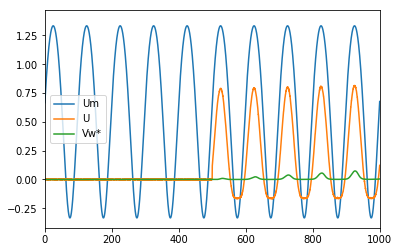

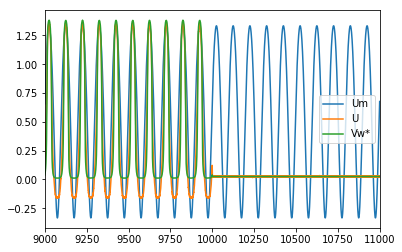

In [130]:
plt.plot(t_c,Um_ref,label='Um')
plt.plot(t,meas_dict['U'][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*meas_dict['Vw'][:,0],label='Vw*')
plt.xlim([0,1000])
plt.legend()
plt.show()
plt.close()

plt.plot(t_c,Um_ref,label='Um')
plt.plot(t,meas_dict['U'][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*meas_dict['Vw'][:,0],label='Vw*')
plt.xlim([9000,11000])
plt.legend()
plt.show()
plt.close()
    

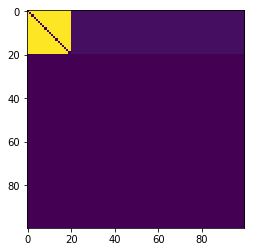

In [131]:
plt.imshow(W.eval())